# Segmentation of Indian Traffic

In [ ]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 450kB 52.2MB/s 
     |████████████████████████████████| 3.9MB 53.0MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=752b8db125d320cc43bea62f12b6ba150142051605174fb1896e582f62222f84
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [ ]:
!curl --header "Host: doc-0k-90-docs.googleusercontent.com" --header "User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9,pa;q=0.8" --header "Cookie: AUTH_pp0n0oquc5c2r320dooslshnqrccu9ln_nonce=vrrhl2eci68bc" --header "Connection: keep-alive" "https://doc-0k-90-docs.googleusercontent.com/docs/securesc/kk53kko5gfgvn9rhjbblp8cfatlspjlv/l6cnqir569ibc1b3hb2medro3c1v7n81/1602155850000/00484516897554883881/03638208136195004336/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=vrrhl2eci68bc&user=03638208136195004336&hash=qr89q9s8s5gi32b1fkfrra7qvp0ikkdf" -L -o 'data.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2231M    0 2231M    0     0  69.2M      0 --:--:--  0:00:32 --:--:-- 30.3M


In [ ]:
import os
import shutil
import glob

In [ ]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/images/377/frame31126_leftImg8bit.jpg  
  inflating: data/imag

# Task 1: Preprocessing

In [ ]:
root_dir = 'data'
all_files = os.listdir('data')
print(all_files)

['mask', 'images']


In [ ]:
os.mkdir('data/output')

In [ ]:
root_dir = 'data'
all_files = os.listdir('data')
print(all_files)

['output', 'mask', 'images']


## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    
    all_files_path_image = []
    all_files_path_json = []

    # https://stackoverflow.com/questions/16150868/sorting-strings-by-a-substring-in-python
    for dir in os.listdir('{}/images'.format(root_dir)):
      all_files_path_image.extend(sorted(glob.glob('{0}/images/{1}/*.jpg'.format(root_dir,dir)), key=lambda x: str((x.split('_')[0]).split('/')[-1])))
    for dir in os.listdir('{}/mask'.format(root_dir)):
      all_files_path_json.extend(sorted(glob.glob('{0}/mask/{1}/*.json'.format(root_dir, dir)), key=lambda x: str((x.split('_')[0]).split('/')[-1])))
    
    all_files_path_image = np.array(all_files_path_image)
    all_files_path_json = np.array(all_files_path_json)

    # Creating data frame
    data_df = pd.DataFrame({
      'image' : all_files_path_image,
      'json' : all_files_path_json
    })
    return data_df

In [ ]:
sub_sub_drs = set()
for dir in os.listdir('{}/images'.format(root_dir)):
  sub_sub_drs.add(dir)
sub_sub_drs = list(sub_sub_drs)

In [ ]:
for dir in sub_sub_drs:
  os.mkdir('data/output/{}'.format(dir))

In [ ]:
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/339/frame0014_leftImg8bit.jpg,data/mask/339/frame0014_gtFine_polygons.json
1,data/images/339/frame0837_leftImg8bit.jpg,data/mask/339/frame0837_gtFine_polygons.json
2,data/images/339/frame1242_leftImg8bit.jpg,data/mask/339/frame1242_gtFine_polygons.json
3,data/images/339/frame1512_leftImg8bit.jpg,data/mask/339/frame1512_gtFine_polygons.json
4,data/images/339/frame1722_leftImg8bit.jpg,data/mask/339/frame1722_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

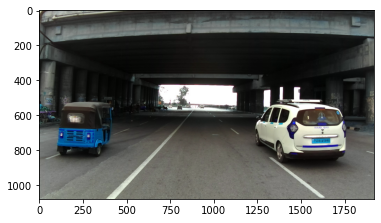

In [ ]:
img = cv.imread('data/images/348/frame5999_leftImg8bit.jpg')
plt.imshow(img)

In [ ]:
img.shape

(1080, 1920, 3)

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
from tqdm import tqdm

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and return them
    # if open any json file using any editor you will get better sense of it
    unique_labels = set()
    for file_index in tqdm(range(data_df.shape[0])):
      f = open(data_df.iloc[file_index]['json'])
      data = json.load(f)
      f.close()
      for label_index in range(len(data['objects'])):
        unique_labels.add(data['objects'][label_index]['label'])
    unique_labels = np.array(list(unique_labels))
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

100%|██████████| 4008/4008 [00:19<00:00, 205.95it/s]


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    f = open(file)
    data = json.load(f)
    f.close()
    w = data['imgWidth']
    h = data['imgHeight']
    label = []
    vertexlist = []
    for obj in data['objects']:
      label.append(obj['label'])
      if len(obj['polygon']) >= 2:
        vertices = []
        for vertex in obj['polygon']:
          vertices.append(tuple(vertex))
        vertexlist.append(vertices)
    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

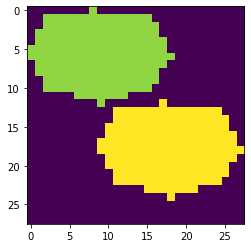

In [ ]:
import math 
from PIL import Image, ImageDraw
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) * 9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) * 9, (math.sin(th) + 3) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill=50)
# writing the second polygon
img1.polygon(x2, fill=60)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
#print(img.shape)
#print(img[:,:,0]//10)
#im = Image.fromarray(img[:,:,0])
#im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    output = []
    for file in tqdm(data_df['json']):
      w, h, labels, vertexlist = get_poly(file)
      img = Image.new('RGB', (w, h))
      img1 = ImageDraw.Draw(img)
      for i in range(len(vertexlist)):
        img1.polygon(vertexlist[i], fill=label_clr[labels[i]])
      img = np.array(img)
      im = Image.fromarray(img[:,:,0])
      img_path = file.split('.')[0].replace('mask', 'output') + ".png"
      im.save(img_path)
      output.append(img_path)

    data_df['mask'] = output

    return data_df

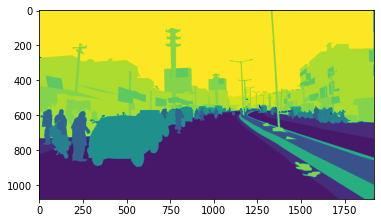

In [ ]:
file = 'data/mask/201/frame0029_gtFine_polygons.json'
w, h, labels, vertexlist = get_poly(file)
img = Image.new('RGB', (w, h))
img1 = ImageDraw.Draw(img)
mask = []
for i in range(len(vertexlist)):
  img1.polygon(vertexlist[i], fill=label_clr[labels[i]])
img = np.array(img)
im = Image.fromarray(img[:,:,0])
img_path = file.split('.')[0].replace('mask', 'output') + ".png"
im.save(img_path)
mask.append(img_path)
plt.imshow(img[:,:,0])

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [03:56<00:00, 16.98it/s]


,image,json,mask
0,data/images/339/frame0014_leftImg8bit.jpg,data/mask/339/frame0014_gtFine_polygons.json,data/output/339/frame0014_gtFine_polygons.png
1,data/images/339/frame0837_leftImg8bit.jpg,data/mask/339/frame0837_gtFine_polygons.json,data/output/339/frame0837_gtFine_polygons.png
2,data/images/339/frame1242_leftImg8bit.jpg,data/mask/339/frame1242_gtFine_polygons.json,data/output/339/frame1242_gtFine_polygons.png
3,data/images/339/frame1512_leftImg8bit.jpg,data/mask/339/frame1512_gtFine_polygons.json,data/output/339/frame1512_gtFine_polygons.png
4,data/images/339/frame1722_leftImg8bit.jpg,data/mask/339/frame1722_gtFine_polygons.json,data/output/339/frame1722_gtFine_polygons.png


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


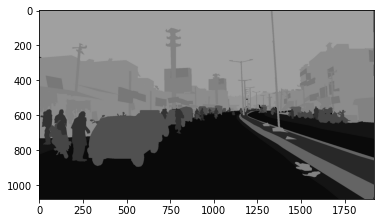

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writing this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

Dice loss formula \begin{equation}
loss = \frac{X\cap Y}{X \cup Y} 
\end{equation}

where X is the area of the actual image and Y is the area of the predicted image.

Range of the dice loss = [0, 1]

Interpretation
  
loss = 0, when there is no common region in the predicted and actual images.

loss = 1, when the actual and predicted image is

Understanding of the loss function

In image segmentation we basically mark regions which belong to a particular object. Using dice loss we measure how much of the actual region is predicted by the model.

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
import imgaug.augmenters as iaa

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

In [ ]:
from sklearn.model_selection import train_test_split
X_train_path, X_test_path = train_test_split(data_df, test_size=0.1, random_state=42)

In [ ]:
train_image_file_names = []
test_image_file_names = []
for i in X_train_path['image']:
    train_image_file_names.append(i.split('.')[0])
for i in X_test_path['image']:
    test_image_file_names.append(i.split('.')[0])
train_image_file_names = np.array(train_image_file_names)
test_image_file_names = np.array(test_image_file_names)

In [ ]:
train_mask_file_names = []
test_mask_file_names = []
for i in X_train_path['mask']:
    train_mask_file_names.append(i.split('.')[0])
for i in X_test_path['mask']:
    test_mask_file_names.append(i.split('.')[0])
train_mask_file_names = np.array(train_mask_file_names)
test_mask_file_names = np.array(test_mask_file_names)

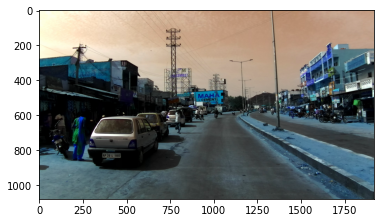

In [ ]:
my_img = cv2.imread('data/images/201/frame0029_leftImg8bit.jpg')
#my_img = cv2.resize(my_img, (512, 512))
plt.imshow(my_img)

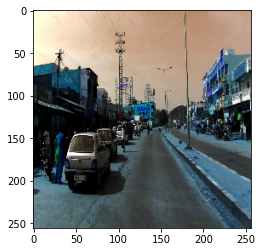

In [ ]:
my_img = cv2.imread('data/images/201/frame0029_leftImg8bit.jpg')
my_img = cv2.resize(my_img, (256, 256))
plt.imshow(my_img)

In [ ]:
!pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-k6d5or2t
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-k6d5or2t
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=b44a7d9df8db3dd9a467bf7255434813a0171b45d273ab7bb28dff630fd1f1ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-jav8jj7l/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Found existing installation: image-classifiers 0.2.0
    Uninstalling image-classifiers-0.2.0:
      Successfully uninstalled image-classifiers-0.2.0
  Found existing installation: segmentation-models 0.2.1
    Uninstalling segmentation-models-0.2.1:
      Successfully uninstalled segmentation-models-0.2.1


In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
import tensorflow as tf

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
from segmentation_models.metrics import iou_score

In [ ]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
  

class Train_Dataset:
    # we will be modifying this CLASSES according to your data/problems
    #CLASSES = ['road', 'parking', 'sidewalk', 'non-drivable track', 'living things', 'rider', 'cycle', 'small vehicle', 'big vehicle', \
               #'wall', 'guard', 'billboard', 'pole', 'far objects', 'vegetation', 'sky', 'ego vehicle', 'ground','rectification border', \
               #'train', 'not for training']
    CLASSES = list(np.unique(list(label_clr.values())))
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_file_names, mask_file_names):
        
        self.image_ids = image_file_names
        self.mask_ids = mask_file_names
        self.images_fps   = [image_id + '.jpg' for image_id in self.image_ids]
        # the paths of segmentation images
        self.masks_fps    = [mask_id + '.png' for mask_id in self.mask_ids]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in CLASSES]
    
    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)//10
        mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_AREA)
        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.image_ids)

class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
class Test_Dataset:
    # we will be modifying this CLASSES according to your data/problems
    #CLASSES = ['road', 'parking', 'sidewalk', 'non-drivable track', 'living things', 'rider', 'cycle', 'small vehicle', 'big vehicle', \
              # 'wall', 'guard', 'billboard', 'pole', 'far objects', 'vegetation', 'sky', 'ego vehicle', 'ground','rectification border', \
              # 'train', 'not for training']
    CLASSES = list(np.unique(list(label_clr.values())))
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_file_names, mask_file_names):
        
        self.image_ids = image_file_names
        self.mask_ids = mask_file_names
        self.images_fps   = [image_id + '.jpg' for image_id in self.image_ids]
        # the paths of segmentation images
        self.masks_fps    = [mask_id + '.png' for mask_id in self.mask_ids]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in CLASSES]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)//10
        mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_AREA)

        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        return image, image_mask

    def __len__(self):
        return len(self.image_ids)
    

In [ ]:
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3), encoder_freeze=True)

85524480/85521592 [==============================] - 7s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
optim = tf.keras.optimizers.Adam(0.001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

In [ ]:
CLASSES = list(np.unique(list(label_clr.values())))

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataset = Train_Dataset(train_image_file_names, train_mask_file_names)
test_dataset  = Test_Dataset(test_image_file_names, test_mask_file_names)


train_dataloader = Dataloder(train_dataset, batch_size=64, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=64, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

(64, 256, 256, 3)


In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=7, validation_data=test_dataloader,callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 56 steps, validate for 6 steps
Epoch 1/7
56/56 [==============================] - 345s 6s/step - loss: 0.9085 - iou_score: 0.2933 - val_loss: 1.0458 - val_iou_score: 0.2330
Epoch 2/7
56/56 [==============================] - 329s 6s/step - loss: 0.7671 - iou_score: 0.4008 - val_loss: 0.8885 - val_iou_score: 0.3178
Epoch 3/7
56/56 [==============================] - 327s 6s/step - loss: 0.6859 - iou_score: 0.4590 - val_loss: 0.8119 - val_iou_score: 0.3972
Epoch 4/7
56/56 [==============================] - 327s 6s/step - loss: 0.6334 - iou_score: 0.5080 - val_loss: 0.7380 - val_iou_score: 0.4396
Epoch 5/7
56/56 [==============================] - 326s 6s/step - loss: 0.6244 - iou_score: 0.5158 - val_loss: 0.6874 - val_iou_score: 0.4741
Epoch 6/7
56/56 [==============================] - 327s 6s/step - loss: 0.6149 - iou_score: 0.5249 - val_loss: 0.6641 - val_iou_score: 0.4916
Epoch 7/7
56/56 [==============================] - 328s 6

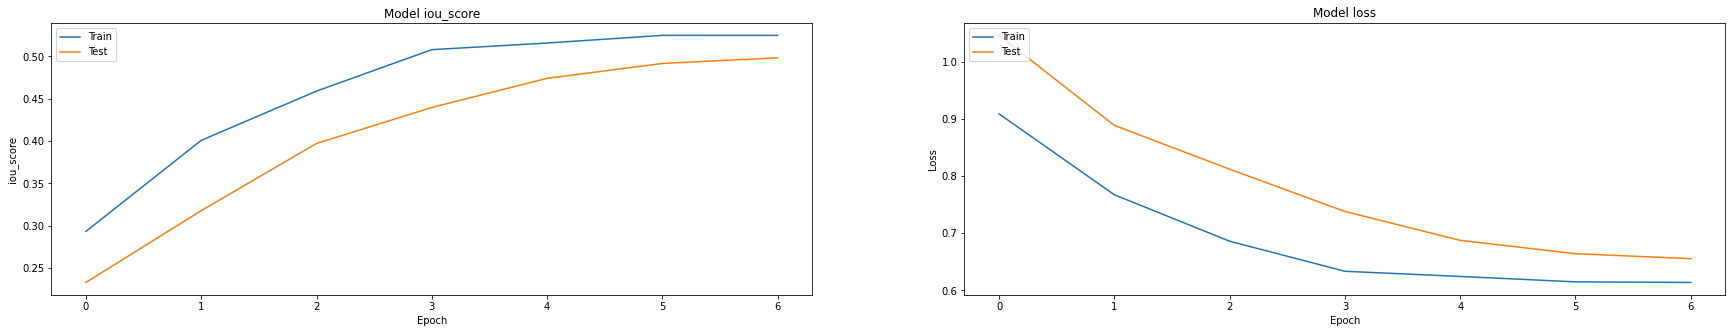

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
for p, i in enumerate(X_test):
    #original image
    image = cv2.imread(list(X_test['image'])[p], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation map
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(list(X_test['mask'])[p], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask) 
    plt.subplot(133)
    plt.imshow(pred_mask[0])
    plt.show()

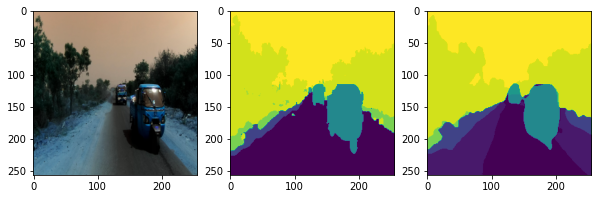

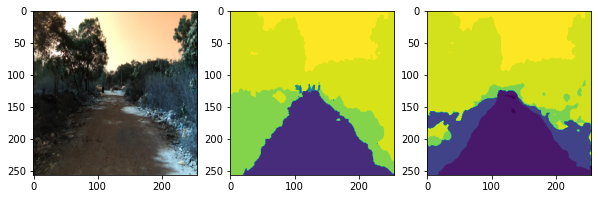

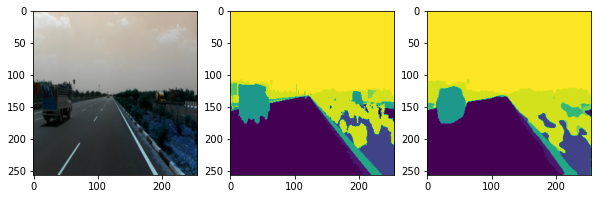

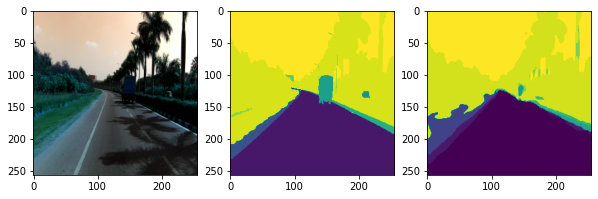

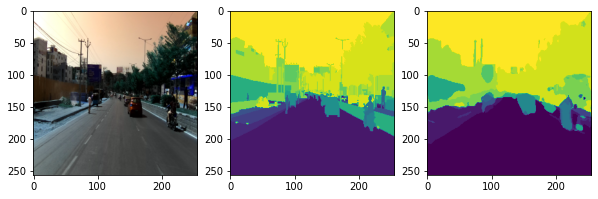

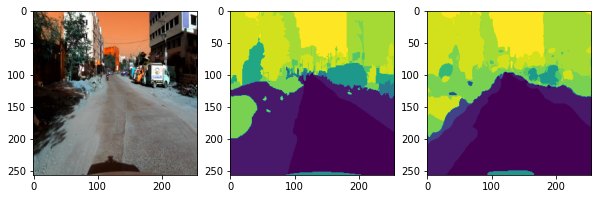

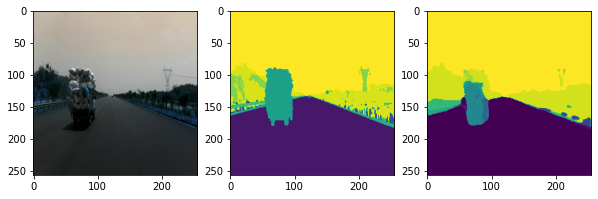

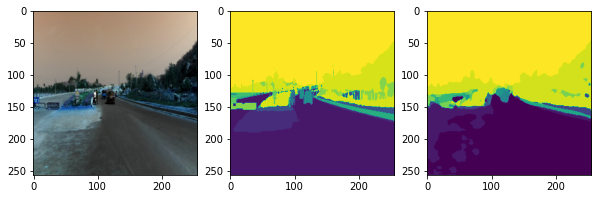

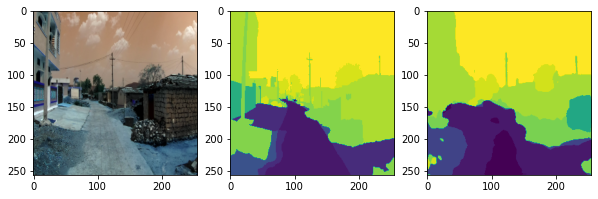

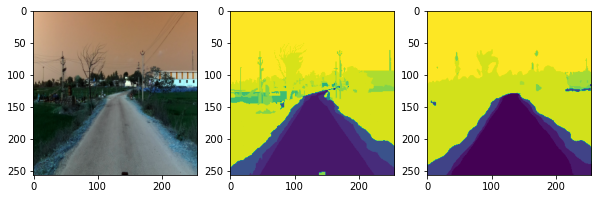

In [ ]:
image_ids = test_image_file_names[:10]
mask_ids = test_mask_file_names[:10]
# the paths of segmentation images
images_fps = [image_id + '.jpg' for image_id in image_ids]
masks_fps = [mask_id + '.png' for mask_id in mask_ids]
for i in range(len(images_fps)):
    #original image
    image = cv2.imread(images_fps[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA) 
    
    #predicted segmentation map
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(masks_fps[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256), interpolation = cv2.INTER_NEAREST)
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask) 
    plt.subplot(133)
    plt.imshow(pred_mask[0])
    plt.show()

# Task 3: Training CANet

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.activations import sigmoid
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
X_input = Input(shape=(256,256,3))

# Stage 1
X = Conv2D(8, 3, name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

(None, 128, 128, 8)


In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, filters=[4,4,8], stride=1, name="conv_block"):

        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.stride = stride

        self.conv2d_top = Conv2D(self.F1, 1, padding = 'same', name = 'conv_top')
        self.batch_norm_top = BatchNormalization(axis=-1, name='bn_conv_top')
        self.activation_top = Activation('relu')

        self.conv2d_middle = Conv2D(self.F2, 3, padding = 'same', name = 'conv2_middle')
        self.batch_norm_middle = BatchNormalization(axis=-1, name='bn_conv_middle')
        self.activation_middle = Activation('relu')
        self.maxpool_middle_stride_1 = MaxPooling2D(pool_size=(2,2), strides=self.stride, padding = 'same')
        self.maxpool_middle = MaxPooling2D(pool_size=(2,2), strides=self.stride)

        self.conv2d_bottom = Conv2D(self.F3, 1, padding = 'same', name = 'conv3_bottom')
        self.batch_norm_bottom = BatchNormalization(axis=-1, name='bn_conv_bottom')
        self.activation_bottom = Activation('relu')

        self.conv2d_parallel = Conv2D(self.F3, 3, padding = 'same', name = 'conv_parallel')
        self.batch_norm_parallel = BatchNormalization(axis=-1, name='bn_conv_parallel')
        self.activation_parallel = Activation('relu')
        self.maxpool_parallel_stride_1 = MaxPooling2D(pool_size=(2,2), strides=self.stride, padding = 'same')
        self.maxpool_parallel = MaxPooling2D(pool_size=(2,2), strides=self.stride)

    def call(self, X):
        X_parallel = X

        # 1*1 Conv
        X = self.conv2d_top(X)
        X = self.batch_norm_top(X)
        X = self.activation_top(X)

        # 3*3 Conv
        X = self.conv2d_middle(X)
        X = self.batch_norm_middle(X)
        X = self.activation_middle(X)
        if self.stride == 1:
          X = self.maxpool_middle_stride_1(X)
        else:
          X = self.maxpool_middle(X)

        # 1*1 Conv
        X = self.conv2d_bottom(X)
        X = self.batch_norm_bottom(X)

        # Parallel 3*3 Conv
        X_parallel = self.conv2d_parallel(X_parallel)
        X_parallel = self.batch_norm_parallel(X_parallel)
        X_parallel = self.activation_parallel(X_parallel)
        if self.stride == 1:
          X_parallel = self.maxpool_parallel_stride_1(X_parallel)
        else:
          X_parallel = self.maxpool_parallel(X_parallel)
  
        # Elementwise summation
        X = tf.math.accumulate_n([X, X_parallel])
        X = self.activation_bottom(X)

        return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, filters=[4,4,8], name="identity_block"):

        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters

        self.conv2d_top = Conv2D(self.F1, 1, padding='same', name = 'conv1')
        self.batch_norm_top = BatchNormalization(axis=-1, name='bn_conv1')
        self.activation_top = Activation('relu')

        self.conv2d_middle = Conv2D(self.F2, 3, padding='same', name = 'conv2')
        self.batch_norm_middle = BatchNormalization(axis=-1, name='bn_conv2')
        self.activation_middle = Activation('relu')

        self.conv2d_bottom = Conv2D(self.F3, 1, padding = 'same', name = 'conv3')
        self.batch_norm_bottom = BatchNormalization(axis=-1)
        self.activation_bottom = Activation('relu')

    def call(self, X):
        X_1 = X
        # 1*1 Conv
        X = self.conv2d_top(X)
        X = self.batch_norm_top(X)
        X = self.activation_top(X)
        # 3*3 Conv
        X = self.conv2d_middle(X)
        X = self.batch_norm_middle(X)
        X = self.activation_middle(X)
        # 1*1 Conv
        X = self.conv2d_bottom(X)
        X = self.batch_norm_bottom(X)
        # Elementwise summation
        X = tf.math.accumulate_n([X, X_1])
        X = self.activation_bottom(X)

        return X

In [ ]:
# Calculating C_1
C_1_conv_block = convolutional_block(filters=[4,4,8], stride=2, name='conv_block_C_1')
C_1_conv_block_output = C_1_conv_block(X)
C_1_iden_block = identity_block(filters=[4,4,8], name='identity_block_C_1')
C_1_iden_block_output = C_1_iden_block(C_1_conv_block_output)
print('C_1_conv_block_output shape', C_1_iden_block_output.shape)
print('C_1_iden_block_output shape', C_1_iden_block_output.shape)
# Calculating C_2
C_2_conv_block = convolutional_block(filters=[8,8,16], stride=2, name='conv_block_C_2')
C_2_conv_block_output = C_2_conv_block(C_1_iden_block_output) 
C_2_iden_block = identity_block(filters=[8,8,16], name='identity_block_C_2')
C_2_conv_block_output = C_2_iden_block(C_2_conv_block_output) 
C_2_iden_block_output = C_2_iden_block(C_2_conv_block_output)
print('C_2_conv_block_output shape', C_2_iden_block_output.shape)
print('C_2_iden_block_output shape', C_2_iden_block_output.shape)
# Calculating C_3
C_3_conv_block = convolutional_block(filters=[8,8,16], name='conv_block_C_3')
C_3_conv_block_output = C_3_conv_block(C_2_iden_block_output) 
C_3_iden_block = identity_block(filters=[8,8,16], name='identity_block_C_3')
C_3_iden_block_output = C_3_iden_block(C_3_conv_block_output)
for i in range(2):
  C_3_iden_block_output = C_3_iden_block(C_3_iden_block_output)
print('C_3_conv_block_output shape', C_3_iden_block_output.shape)
print('C_3_iden_block_output shape', C_3_iden_block_output.shape)
# Calculating C_4
C_4_conv_block = convolutional_block(filters=[8,8,16], name='conv_block_C_4')
C_4_conv_block_output = C_4_conv_block(C_3_iden_block_output)
C_4_iden_block = identity_block(filters=[8,8,16], name='identity_block_c_4')
C_4_iden_block_output = C_4_iden_block(C_4_conv_block_output)
for i in range(3):
  C_4_iden_block_output = C_4_iden_block(C_4_iden_block_output)
print('C_4_conv_block_output shape', C_4_iden_block_output.shape)
print('C_4_iden_block_output shape', C_4_iden_block_output.shape)

C_1_conv_block_output shape (None, 64, 64, 8)
C_1_iden_block_output shape (None, 64, 64, 8)
C_2_conv_block_output shape (None, 32, 32, 16)
C_2_iden_block_output shape (None, 32, 32, 16)
C_3_conv_block_output shape (None, 32, 32, 16)
C_3_iden_block_output shape (None, 32, 32, 16)
C_4_conv_block_output shape (None, 32, 32, 16)
C_4_iden_block_output shape (None, 32, 32, 16)


* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_width, input_height, name="global_flow"):
        super().__init__(name=name)
        self.input_width = input_width
        self.input_height = input_height
        self.global_average_pool = GlobalAveragePooling2D()
        self.batch_norm = BatchNormalization(axis=-1, name='bn_global')
        self.activation = Activation('relu')
        self.conv2d = Conv2D(8, 1) 
        self.upsampling2d = UpSampling2D(size=(self.input_width, self.input_height), interpolation='bilinear')
    def call(self, X):
        # Implementing the global flow operation
        X = self.global_average_pool(X)
        X = tf.expand_dims(tf.expand_dims(X, 1), 1)
        X = self.batch_norm(X)
        X = self.activation(X)
        X = self.conv2d(X)
        X = self.upsampling2d(X)

        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.average_pool = AveragePooling2D(pool_size=(2,2))
        self.conv2d_1 = Conv2D(8, 3, padding='same')
        self.conv2d_2 = Conv2D(8, 3, padding='same')
        self.conv2d_3 = Conv2D(8, 1, padding='same')
        self.conv2d_4 = Conv2D(8, 1, padding='same')
        self.activation_relu = Activation('relu')
        self.activation_sigmoid = Activation('sigmoid')
        self.upsampling2d =  UpSampling2D(size=(2, 2), interpolation='bilinear')
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1]
        X = tf.concat([INP, FLOW], axis=-1)
        X = self.average_pool(X)
        X = self.conv2d_1(X)
        X_conv2 = self.conv2d_2(X)
        X = self.conv2d_3(X_conv2)
        X = self.activation_relu(X)
        X = self.conv2d_4(X)
        X = self.activation_sigmoid(X)
        X = tf.math.multiply(X_conv2, X)
        X = tf.math.accumulate_n([X_conv2, X])
        X = self.upsampling2d(X)

        return X

In [ ]:
C_4_iden_block_output.shape

TensorShape([None, 32, 32, 16])

In [ ]:
# Global flow
global_flow_object = global_flow(C_4_iden_block_output.shape[1], C_4_iden_block_output.shape[2])
global_flow_output = global_flow_object(C_4_iden_block_output)
print('global_flow_output shape', global_flow_output.shape)

# Context flow 1
context_flow_1_input = [C_4_iden_block_output, global_flow_output]
context_flow_1 = context_flow(name='context_flow_1')
context_flow_1_output = context_flow_1(context_flow_1_input)
print('context_flow_1_output shape', context_flow_1_output.shape)

# Context flow 2
context_flow_2_input = [C_4_iden_block_output, context_flow_1_output]
context_flow_2 = context_flow(name='context_flow_2')
context_flow_2_output = context_flow_2(context_flow_2_input)
print('context_flow_2_output shape', context_flow_2_output.shape)

# Context flow 3
context_flow_3_input = [C_4_iden_block_output, context_flow_2_output]
context_flow_3 = context_flow(name='context_flow_3')
context_flow_3_output = context_flow_3(context_flow_3_input)
print('context_flow_3_output shape', context_flow_3_output.shape)

# Concatenation of global and context flows
fsm_input = tf.math.accumulate_n([global_flow_output, context_flow_1_output, context_flow_2_output, context_flow_3_output])
print('fsm_input shape', fsm_input.shape)

global_flow_output shape (None, 32, 32, 8)
context_flow_1_output shape (None, 32, 32, 8)
context_flow_2_output shape (None, 32, 32, 8)
context_flow_3_output shape (None, 32, 32, 8)
fsm_input shape (None, 32, 32, 8)


* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv2d_1 = Conv2D(8, 3, padding='same')
        self.global_max_pool = GlobalMaxPooling2D()
        self.conv2d_2 = Conv2D(8, 1)
        self.batch_norm = BatchNormalization(axis=-1, name='bn_fsm')
        self.activation = Activation('sigmoid')
        
    def call(self, X):
        X_conv1 = self.conv2d_1(X)
        X = self.global_max_pool(X_conv1)
        X = tf.expand_dims(tf.expand_dims(X, 1), 1)
        X = self.conv2d_2(X)
        X = self.batch_norm(X)
        X = self.activation(X)
        X = tf.math.multiply(X_conv1, X)

        return X

In [ ]:
# FSM 
fsm_object = fsm()
fsm_output = fsm_object(fsm_input)
fsm_output = UpSampling2D(size=(2,2), interpolation='bilinear')(fsm_output)
fsm_output.shape

TensorShape([None, 64, 64, 8])

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv_left_1 = Conv2D(8,(7,1), strides=(1,1), padding='same')
        self.conv_left_2 = Conv2D(8, (1,7), strides=(1,1), padding='same')
        self.conv_right_1 = Conv2D(8, (1,7), strides=(1,1), padding='same')
        self.conv_right_2 =  Conv2D(8, (7, 1), strides=(1,1), padding='same')
        self.conv_last = Conv2D(8, 3, strides=(1,1), padding='same')
        
    def call(self, X):
        conv_left_1 = self.conv_left_1(X)
        conv_left_2 = self.conv_left_2(conv_left_1)
        conv_right_1 = self.conv_right_1(X)
        conv_right_2 = self.conv_right_2(conv_right_1)
        element_wise_sum = tf.math.accumulate_n([conv_left_2, conv_right_2])
        conv_last = self.conv_last(element_wise_sum)
        X = tf.math.accumulate_n([conv_last, element_wise_sum])

        return X

In [ ]:
# AGCN
agcn_object = agcn()
agcn_output = agcn_object(C_1_iden_block_output)
agcn_output.shape

TensorShape([None, 64, 64, 8])

In [ ]:
fsm_output.shape

TensorShape([None, 64, 64, 8])

In [ ]:
# Concatenation of outputs of FSM and AGCN
concat_agcn_fsm = tf.concat([agcn_output, fsm_output], -1)
concat_agcn_fsm.shape

TensorShape([None, 64, 64, 16])

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [ ]:
conv_layer = Conv2D(21, 3, strides=(1,1), padding='same')(concat_agcn_fsm)
conv_layer_output = Activation('relu')(conv_layer)
upsampling = UpSampling2D(size=(4,4), interpolation='bilinear')(conv_layer_output)
output = Activation('softmax')(upsampling)
output.shape

TensorShape([None, 256, 256, 21])

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
# write the complete architecutre

model = Model(inputs = X_input, outputs = output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 8)  32          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           bn_conv1[0][0]                   
______________________________________________________________________________________________

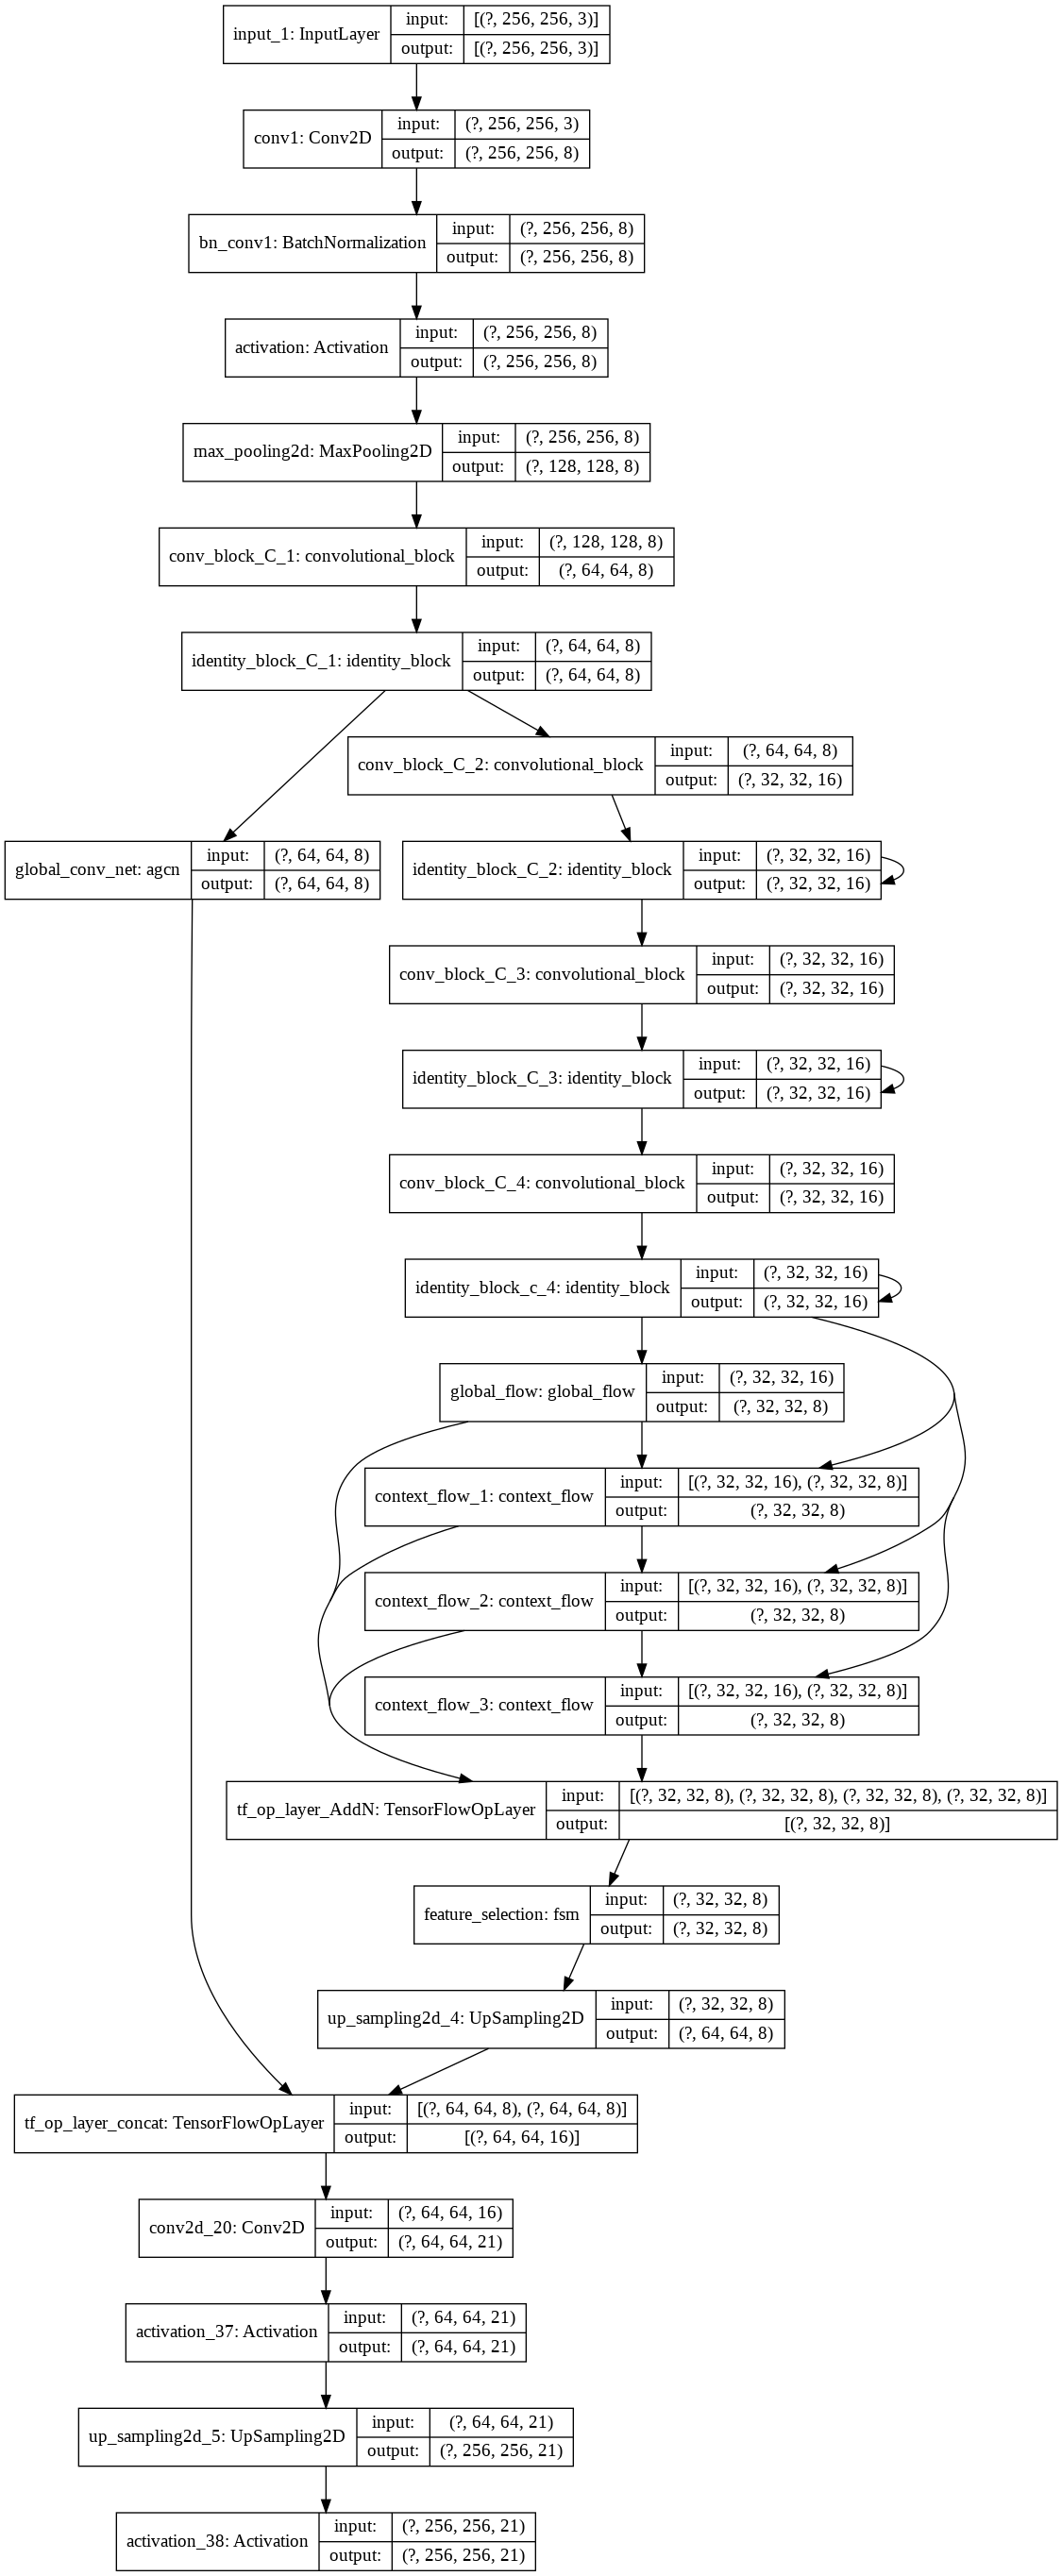

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
optim = tf.keras.optimizers.Adam(0.01)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=8, validation_data=test_dataloader,callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 56 steps, validate for 6 steps
Epoch 1/8
56/56 [==============================] - 347s 6s/step - loss: 1.0142 - iou_score: 0.1808 - val_loss: 1.0187 - val_iou_score: 0.2462
Epoch 2/8
56/56 [==============================] - 335s 6s/step - loss: 0.8908 - iou_score: 0.2867 - val_loss: 1.0022 - val_iou_score: 0.2349
Epoch 3/8
56/56 [==============================] - 335s 6s/step - loss: 0.8518 - iou_score: 0.3164 - val_loss: 1.0186 - val_iou_score: 0.2723
Epoch 4/8
56/56 [==============================] - 335s 6s/step - loss: 0.8276 - iou_score: 0.3362 - val_loss: 0.9789 - val_iou_score: 0.2776
Epoch 5/8
56/56 [==============================] - 336s 6s/step - loss: 0.8007 - iou_score: 0.3667 - val_loss: 0.8595 - val_iou_score: 0.3490
Epoch 6/8
56/56 [==============================] - 334s 6s/step - loss: 0.7895 - iou_score: 0.3749 - val_loss: 0.8226 - val_iou_score: 0.3693
Epoch 7/8
56/56 [==============================] - 338s 6

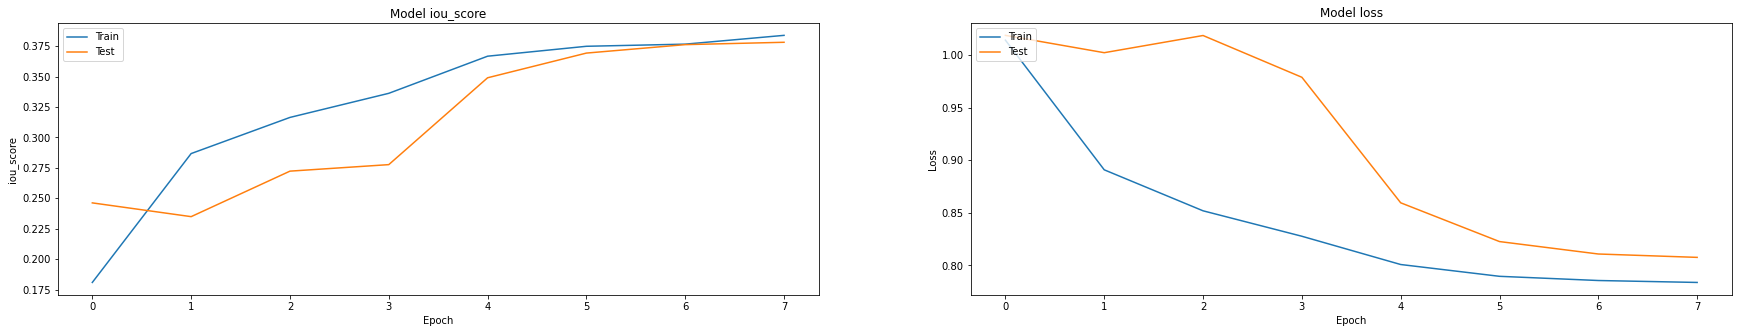

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

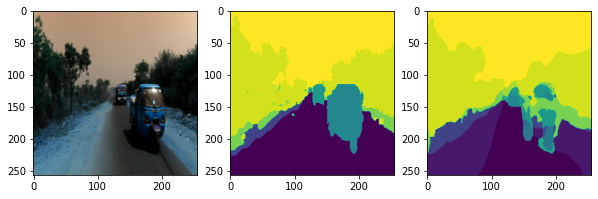

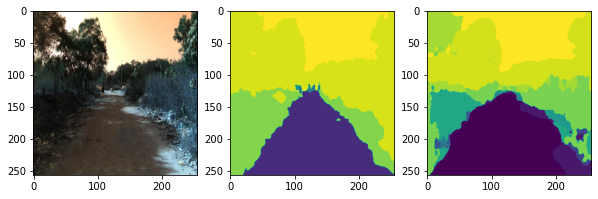

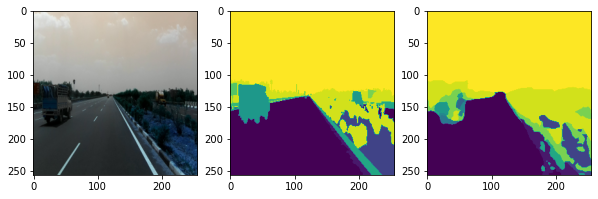

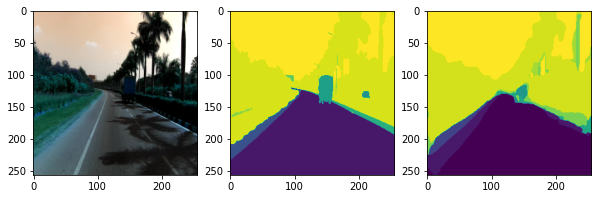

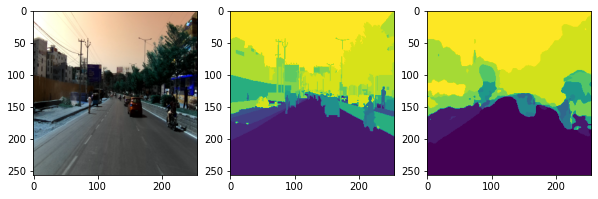

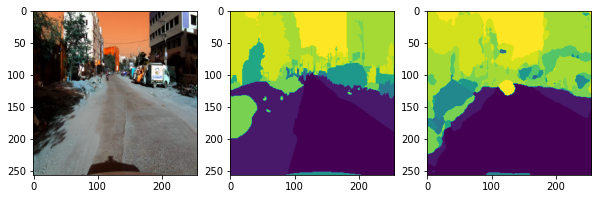

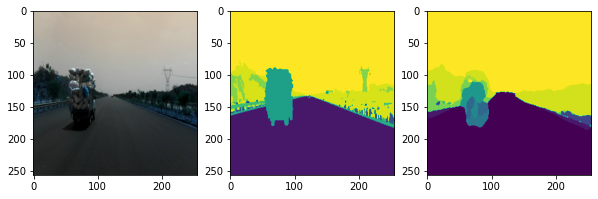

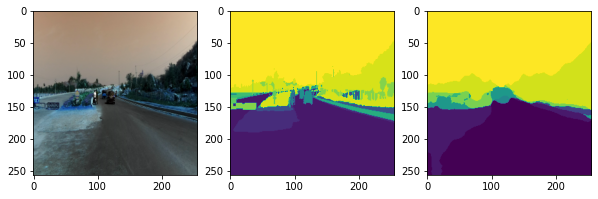

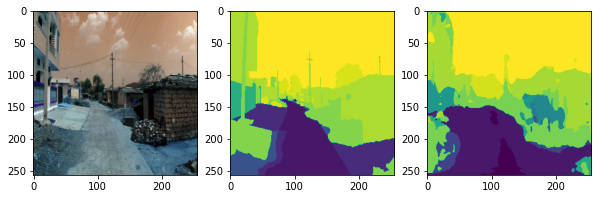

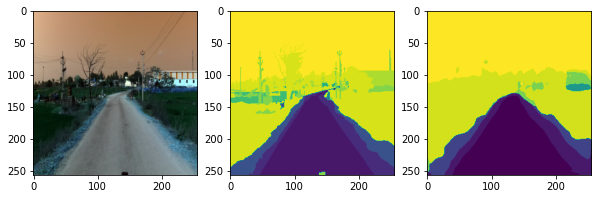

In [ ]:
image_ids = test_image_file_names[:10]
mask_ids = test_mask_file_names[:10]
# the paths of segmentation images
images_fps = [image_id + '.jpg' for image_id in image_ids]
masks_fps = [mask_id + '.png' for mask_id in mask_ids]
for i in range(len(images_fps)):
    #original image
    image = cv2.imread(images_fps[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA) 
    
    #predicted segmentation map
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(masks_fps[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256), interpolation = cv2.INTER_NEAREST)
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask) 
    plt.subplot(133)
    plt.imshow(pred_mask[0])
    plt.show()

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations